In [20]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
from tqdm import tqdm
%matplotlib inline

In [2]:
ppy.gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [3]:
plt.style.use('seaborn-poster')

In [4]:
f475w = ppy.instrument.ACS_WFC_F475W(exposure=375.)
f850lp = ppy.instrument.ACS_WFC_F850LP(exposure=560.)

In [5]:
iso_model = ppy.isochrones.Isochrone_Model([f850lp, f475w])

starting manual interpolation
done with interpolation


In [6]:
driv = ppy.driver.Driver(iso_model)

In [10]:
pcmds_r = [np.loadtxt('../data/m49/pcmds/m49_r{:d}_z-gz.pcmd'.format(i), unpack=True) for i in [10, 20, 30]]
pcmds_t = [np.loadtxt('../data/m49/pcmds/m49_t{:d}_z-gz.pcmd'.format(i), unpack=True) for i in [23, 48, 70]]

In [12]:
gal_var_dist = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    ppy.agemodels.TauModel(),
    ppy.distancemodels.VariableDistance()
)
gal_const_dist = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.FixedWidthNormMDF(0.2),
    ppy.dustmodels.SingleDust(),
    ppy.agemodels.TauModel(),
    ppy.distancemodels.FixedDistance(31.29)
)

In [15]:
gal_var_dist.set_params(np.array([0.28403, -1.0053, 4.0944, 5.5998, 30.003]))
gal_

In [13]:
sky_noise = [30.0, 27.6]

In [21]:
pcmds_var = []
for params in tqdm([np.array([0.28403, -1.0053, 4.0944, 5.5998, 30.003]),
                   np.array([0.34383, -1.0071, 4.5058, 5.0624, 30.003]),
                   np.array([0.39149, -1.0121, 5.0702, 4.9586, 30.064])]):
    gal_var_dist.set_params(params)
    pcmds_var.append(driv.simulate(gal_var_dist, 1024, shot_noise=True, sky_noise=sky_noise,
                                   downsample=5)[0])

100%|██████████| 3/3 [00:13<00:00,  4.72s/it]


In [22]:
pcmds_fixed = []
for params in tqdm([np.array([0.40768, -1.0011, 4.6326, 5.9724]),
                    np.array([0.46960, -1.0024, 5.0231, 5.6350]),
                    np.array([0.49514, -1.0065, 5.5654, 5.1708])]):
    gal_const_dist.set_params(params)
    pcmds_fixed.append(driv.simulate(gal_const_dist, 1024, shot_noise=True, sky_noise=sky_noise,
                                   downsample=5)[0])

100%|██████████| 3/3 [00:12<00:00,  4.25s/it]


In [27]:
messages_r = [
    r'Region 10 (3.9 to 5.5 kpc), 470$^2$ pix',
    r'Region 20 (2.1 to 3.0 kpc), 344$^2$ pix',
    r'Region 30 (0.9 to 1.2 kpc), 205$^2$ pix',
]

messages_t = [
    r'Thin Region 23 (3.9 to 5.4 kpc), 309$^2$ pix',
    r'Thin Region 48 (2.1 to 2.8 kpc), 218$^2$ pix',
    r'Thin Region 70 (0.9 to 1.2 kpc), 134$^2$ pix',
]

messages_v = [
    r'Variable Distance Model (log Npix = 4.1, Dmod = 30.0)',
    r'Variable Distance Model (log Npix = 4.5, Dmod = 30.0)',
    r'Variable Distance Model (log Npix = 5.1, Dmod = 30.0)',    
]

messages_f = [
    r'Fixed Distance Model (log Npix = 4.6, Dmod = 31.3)',
    r'Fixed Distance Model (log Npix = 5.0, Dmod = 31.3)',
    r'Fixed Distance Model (log Npix = 5.6, Dmod = 31.3)',    
]


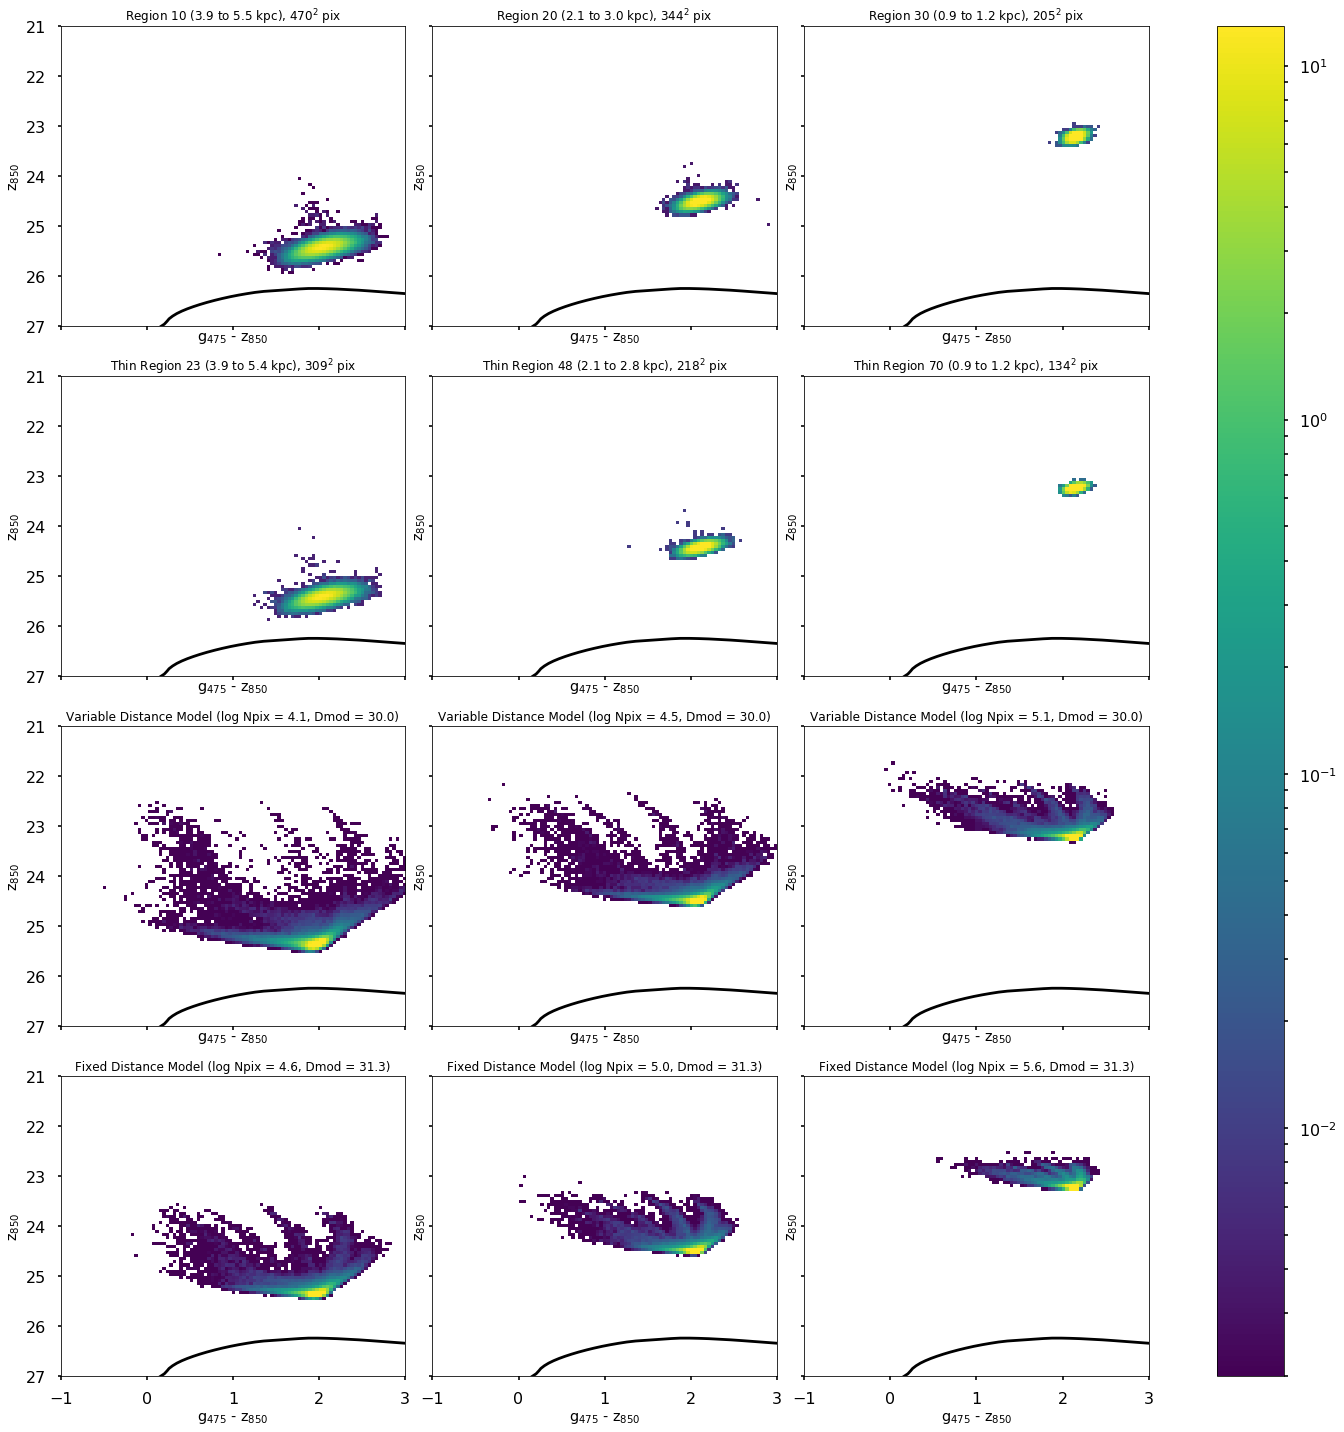

In [32]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(20, 20), sharex=True, sharey=True)
bins = [np.linspace(-1, 3, 100), np.linspace(21, 27, 100)]
norm = mpl.colors.LogNorm()
for i, ax in enumerate(axes[0]):
    pcmd = pcmds_r[i]
    plt.subplot(ax)
    plt.hist2d(pcmd[1], pcmd[0], bins=bins, norm=norm, normed=True)
    ppy.plotting.plot_isochrone(iso_model, dmod=31.29, zorder=-1, axes=ax)
    ax.set_title(messages_r[i].format(i), fontsize=12)
for i, ax in enumerate(axes[1]):
    pcmd = pcmds_t[i]
    plt.subplot(ax)
    plt.hist2d(pcmd[1], pcmd[0], bins=bins, norm=norm, normed=True)
    ppy.plotting.plot_isochrone(iso_model, dmod=31.29, zorder=-1, axes=ax)
    ax.set_title(messages_t[i].format(i), fontsize=12)
for i, ax in enumerate(axes[2]):
    pcmd = pcmds_var[i]
    plt.subplot(ax)
    plt.hist2d(pcmd[1], pcmd[0], bins=bins, norm=norm, normed=True)
    ppy.plotting.plot_isochrone(iso_model, dmod=31.29, zorder=-1, axes=ax)
    ax.set_title(messages_v[i].format(i), fontsize=12)
for i, ax in enumerate(axes[3]):
    pcmd = pcmds_fixed[i]
    plt.subplot(ax)
    plt.hist2d(pcmd[1], pcmd[0], bins=bins, norm=norm, normed=True)
    ppy.plotting.plot_isochrone(iso_model, dmod=31.29, zorder=-1, axes=ax)
    ax.set_title(messages_f[i].format(i), fontsize=12)
plt.tight_layout()
plt.colorbar(ax=axes)
plt.savefig('figures/m49_pcmds_compare.pdf')